In [45]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import plotly.express as px
import json
import numpy as np
# Process the 'reeds_ba_list' column to expand the sets into individual rows, keeping 'state' intact
from ast import literal_eval

polygons_df = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/US_CAN_MEX_PCA_polygons.csv')
state_to_ba_df = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/state_to_ba_mapping.csv')

# Filter polygons
polygons_df = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Since the instructions for processing the state mapping are a bit unclear,
# Convert the string representation of sets in 'reeds_ba_list' to actual sets
state_to_ba_df['reeds_ba_list'] = state_to_ba_df['reeds_ba_list'].apply(literal_eval)

# Explode the sets into separate rows
exploded_df = state_to_ba_df.explode('reeds_ba_list')[['state','reeds_ba_list']]
polygons_df_filtered = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]
polygons_gdf = gpd.GeoDataFrame(polygons_df_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_df_filtered['WKT']))

# Step 2: Merge exploded_df with polygons_gdf on the 'reeds_ba_list' and 'rb' columns
merged_gdf = polygons_gdf.merge(exploded_df, left_on='rb', right_on='reeds_ba_list')
merged_gdf['country']='USA'
merged_gdf=merged_gdf[['rb','state','country','geometry']]

# Country - Group by 'country' and dissolve to merge geometries
gdf_country = merged_gdf.dissolve(by='country').reset_index()

# State - Group by 'state' and dissolve to merge geometries
gdf_state = merged_gdf.dissolve(by='state').reset_index()

# Subregion (rb) - No need to group since each 'rb' is already unique
gdf_subregion = merged_gdf[['rb', 'geometry']].drop_duplicates()


# Convert each GeoDataFrame to GeoJSON for use in Plotly
geojson_country = json.loads(gdf_country.to_json())
geojson_state = json.loads(gdf_state.to_json())
geojson_subregion = json.loads(gdf_subregion.to_json())
# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Graph(id='usa-map', style={'display': 'inline-block', 'width': '70%'}),
        html.Div([
            dcc.RadioItems(
                id='map-toggle',
                options=[
                    {'label': 'Whole Country', 'value': 'country'},
                    {'label': 'By State', 'value': 'state'},
                    {'label': 'By Subregion', 'value': 'subregion'},
                ],
                value='country',  # Default value
                style={'padding': 20}
            ),
            dcc.Dropdown(id='graph-toggle',value='USA',  multi=True)
        ], style={'display': 'inline-block', 'width': '30%', 'verticalAlign': 'top'}),
    ]),
    html.Div([
        dcc.Graph(id='line-graph'),  # Placeholder for the line graph
    ], style={'paddingTop': 20})
])

@app.callback(
    Output('usa-map', 'figure'),
    Input('map-toggle', 'value')
)


def update_map(toggle_value):
    # Choose the correct DataFrame and title based on toggle_value
    if toggle_value == 'country':
        data = gdf_country
        geojson = geojson_country
        color_column = 'country'
    elif toggle_value == 'state':
        data = gdf_state
        geojson = geojson_state
        color_column = 'state'
    else:  # Assuming 'subregion'
        data = gdf_subregion
        geojson = geojson_subregion
        color_column = 'rb'

    # Use Plotly Express to create the choropleth map with a Mapbox base map
    fig = px.choropleth_mapbox(data, geojson=geojson, 
                               locations=data.index, 
                               color=color_column,
                               mapbox_style="white-bg",
                               zoom=3, center={"lat": 37.0902, "lon": -95.7129},
                               opacity=0.5)

    # Add USGS Imagery base map
    fig.update_layout(
        mapbox_layers=[
            {
                "below": 'traces',
                "sourcetype": "raster",
                "source": [
                    "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
                ]
            }
        ]
    )

    # Update layout for no margin and title
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, title=f"Map by {toggle_value.title()}")

    return fig
@app.callback(
    [Output('graph-toggle', 'options'),
     Output('graph-toggle', 'value')],
    [Input('map-toggle', 'value')]
)
def set_graph_toggle_options(selected_map_view):
    print(f"Selected map view: {selected_map_view}")
    if selected_map_view == 'country':
        # Explicitly return 'USA' as the option
        options = [{'label': 'USA', 'value': 'USA'}]
        value='USA'
    elif selected_map_view == 'state':
        # Example state list; replace with your actual data or method to retrieve states
        state_list = ['California', 'New York', 'Texas', 'Florida', 'Illinois']
        options = [{'label': state, 'value': state} for state in state_list]
        value='New York'
    elif selected_map_view == 'subregion':
        # Generate subregion options from 'p1' to 'p134'
        options = [{'label': f'p{i}', 'value': f'p{i}'} for i in range(1, 135)]
        value='p1'
    print(options)

    return options,value

if __name__ == '__main__':
    app.run_server(debug=True)


Selected map view: country
[{'label': 'USA', 'value': 'USA'}]
Selected map view: country
[{'label': 'USA', 'value': 'USA'}]
Selected map view: country
[{'label': 'USA', 'value': 'USA'}]


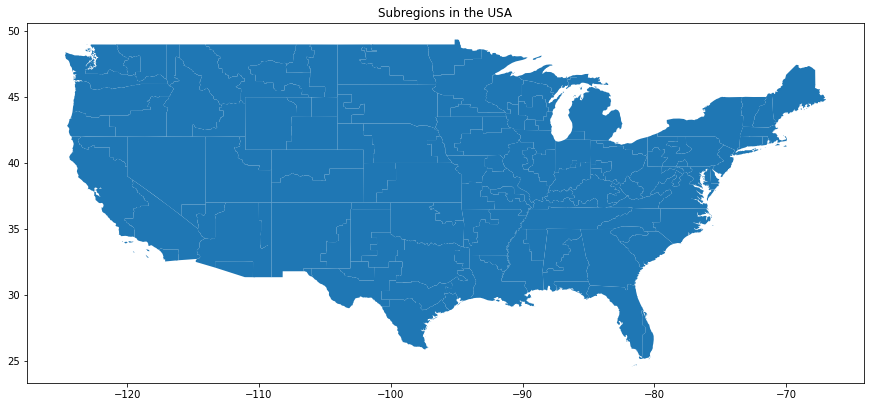

In [11]:
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt 
# Load the polygon data
polygons_gdf = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/US_CAN_MEX_PCA_polygons.csv')

# Filter the GeoDataFrame to keep only the specified 'rb' values
polygons_gdf_filtered = polygons_gdf[polygons_gdf['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Convert WKT to a GeoDataFrame for easier plotting
polygons_gdf_filtered = gpd.GeoDataFrame(polygons_gdf_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_gdf_filtered['WKT']))

# Plotting using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
polygons_gdf_filtered.plot(ax=ax)

# Setting up the plot details
ax.set_title("Subregions in the USA")
plt.show()


In [12]:
state_to_ba_df = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/state_to_ba_mapping.csv')
state_to_ba_df

,Unnamed: 0,state,reeds_ba_list
0,0,Alabama,"{'p89', 'p90'}"
1,1,Arizona,"{'p28', 'p30', 'p29', 'p27'}"
2,2,Arkansas,"{'p56', 'p85'}"
3,3,California,"{'p9', 'p11', 'p8', 'p10'}"
4,4,Colorado,"{'p34', 'p33'}"
5,5,Connecticut,{'p132'}
6,6,Delaware,{'p125'}
7,7,District of Columbia,{'p123'}
8,8,Florida,"{'p102', 'p91', 'p101'}"
9,9,Georgia,{'p94'}


In [21]:
# Process the 'reeds_ba_list' column to expand the sets into individual rows, keeping 'state' intact
from ast import literal_eval
polygons_df = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/US_CAN_MEX_PCA_polygons.csv')
state_to_ba_df = pd.read_csv('/Users/ansonkong/Downloads/NYU_work_repo/resources/state_to_ba_mapping.csv')

# Filter polygons
polygons_df = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]

# Since the instructions for processing the state mapping are a bit unclear,
# Convert the string representation of sets in 'reeds_ba_list' to actual sets
state_to_ba_df['reeds_ba_list'] = state_to_ba_df['reeds_ba_list'].apply(literal_eval)

# Explode the sets into separate rows
exploded_df = state_to_ba_df.explode('reeds_ba_list')[['state','reeds_ba_list']]
polygons_df_filtered = polygons_df[polygons_df['rb'].isin([f'p{i}' for i in range(1, 135)])]
polygons_gdf = gpd.GeoDataFrame(polygons_df_filtered, geometry=gpd.GeoSeries.from_wkt(polygons_df_filtered['WKT']))

# Step 2: Merge exploded_df with polygons_gdf on the 'reeds_ba_list' and 'rb' columns
merged_gdf = polygons_gdf.merge(exploded_df, left_on='rb', right_on='reeds_ba_list')
merged_gdf['country']='USA'
merged_gdf=merged_gdf[['rb','state','country','geometry']]

In [41]:
state_list = ['California', 'New York', 'Texas', 'Florida', 'Illinois']
options = [{'label': state, 'value': state} for state in state_list]
options

[{'label': 'California', 'value': 'California'},
 {'label': 'New York', 'value': 'New York'},
 {'label': 'Texas', 'value': 'Texas'},
 {'label': 'Florida', 'value': 'Florida'},
 {'label': 'Illinois', 'value': 'Illinois'}]